# **Data Input**

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data1 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2013_timeseries.csv")
data2 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2014_timeseries.csv")
data3 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2015_timeseries.csv")
data4 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2016_timeseries.csv")
data5 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2017_timeseries.csv")
data6 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2018_timeseries.csv")
data7 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2019_timeseries.csv")

In [ ]:
ozone_charleroi = pd.concat([data1,data2,data3,data4,data5,data6,data7])

In [ ]:
columns_remove = ['AirPollutant','DatetimeEnd','AirQualityStationEoICode','AirQualityStation','Countrycode','Namespace','AirQualityNetwork','SamplingProcess','SamplingPoint','Sample','AirPollutantCode','AveragingTime','UnitOfMeasurement','Validity','Verification']
ozone_charleroi = ozone_charleroi.drop(columns=columns_remove)

In [ ]:
ozone_charleroi['DatetimeBegin'] = ozone_charleroi['DatetimeBegin'].str[:-7]
ozone_charleroi['DatetimeBegin'] = pd.to_datetime(ozone_charleroi['DatetimeBegin'])

In [ ]:
ozone_charleroi = ozone_charleroi.sort_values(by='DatetimeBegin')
ozone_charleroi = ozone_charleroi.groupby('DatetimeBegin')['Concentration'].mean().reset_index()

In [ ]:
#ozone_charleroi.to_csv("/content/drive/My Drive/DataThesis/ozone_charleroi.csv", index=False)

In [ ]:
ozone_charleroi_ori = ozone_charleroi.copy()

In [ ]:
import random

# Set the seed
random.seed(19)

In [ ]:
obj = 0.20 # Percentage of observations that are going to be removed, to interpolate the removed observations and compute the MSE.

# **Exploratory Data Analysis**

## Data Features

In [ ]:
describe_full = ozone_charleroi['Concentration'].describe()
describe_full

count    58632.000000
mean        38.855557
std         28.472219
min          0.000000
25%         16.500000
50%         36.500000
75%         55.000000
max        224.500000
Name: Concentration, dtype: float64

In [ ]:
nan_count = ozone_charleroi['Concentration'].isna().sum()
print("Number of NaN values in 'Concentration':", nan_count)

Number of NaN values in 'Concentration': 2711


In [ ]:
num_missing = (nan_count/ozone_charleroi['Concentration'].count())*100
num_missing = round(num_missing,2)
print(f"The number of missing observations is: {num_missing}% for the 7 years of data.")

The number of missing observations is: 4.62% for the 7 years of data.


Now lets check the separation of the missing values in the data.

In [ ]:
nan_indices = ozone_charleroi[ozone_charleroi['Concentration'].isna()].index

In [ ]:
# Initialize a dictionary to store the counts of differences
diff_counts = {}

# Iterate through the list of indices
for i in range(len(nan_indices) - 1):
    # Calculate the difference between consecutive indices
    diff = nan_indices[i + 1] - nan_indices[i]

    # Increment the count for this difference in the dictionary
    if diff in diff_counts:
        diff_counts[diff] += 1
    else:
        diff_counts[diff] = 1

# Print the counts of differences
print("Counts of differences in missing values indices:")
for diff, count in diff_counts.items():
    print(f"Difference {diff}: {count} occurrences")

Counts of differences in missing values indices:
Difference 1: 1279 occurrences
Difference 6: 6 occurrences
Difference 47: 1133 occurrences
Difference 32: 7 occurrences
Difference 15: 7 occurrences
Difference 13: 4 occurrences
Difference 44: 4 occurrences
Difference 3: 7 occurrences
Difference 30: 5 occurrences
Difference 14: 7 occurrences
Difference 31: 5 occurrences
Difference 7: 6 occurrences
Difference 8: 6 occurrences
Difference 17: 7 occurrences
Difference 39: 6 occurrences
Difference 24: 6 occurrences
Difference 23: 8 occurrences
Difference 22: 5 occurrences
Difference 10: 8 occurrences
Difference 18: 11 occurrences
Difference 29: 8 occurrences
Difference 45: 8 occurrences
Difference 2: 10 occurrences
Difference 34: 2 occurrences
Difference 46: 5 occurrences
Difference 11: 6 occurrences
Difference 35: 11 occurrences
Difference 36: 8 occurrences
Difference 16: 7 occurrences
Difference 43: 4 occurrences
Difference 27: 6 occurrences
Difference 19: 16 occurrences
Difference 28: 11 o

## Outliers Analysis

### Outliers using IQR

In [ ]:
concentration_values = ozone_charleroi['Concentration']

In [ ]:
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = concentration_values.quantile(0.25)
Q3 = concentration_values.quantile(0.75)

# Interquartile Range (IQR)
IQR = Q3 - Q1

# Boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
outliers_count = ((concentration_values < lower_bound) | (concentration_values > upper_bound)).sum()

# Print the count
print("Number of outliers in 'column_name':", outliers_count)

Number of outliers in 'column_name': 1095


In [ ]:
outlier_indices = concentration_values[(concentration_values < lower_bound) | (concentration_values > upper_bound)].index

# Remove the outliers from the DataFrame
char_ozone_clean_IQR = ozone_charleroi.drop(outlier_indices)

# Here I reset index
char_ozone_clean_IQR.reset_index(drop=True, inplace=True)

In [ ]:
describe_IQR = char_ozone_clean_IQR['Concentration'].describe()

### Outliers using Z-score ###

In [ ]:
# Calculate mean and standard deviation
mean = concentration_values.mean()
std_dev = concentration_values.std()

# Calculate Z-scores
z_scores = (concentration_values - mean) / std_dev

# Define the threshold for outliers
threshold = 3  # Adjust as needed based on your requirements

# Get the indices of outliers
outlier_indices = np.where(np.abs(z_scores) > threshold)[0]

print("Number of outliers in 'Concentrations' using Z-score:", len(outlier_indices))

# Remove the outliers from the DataFrame
char_ozone_clean_zscore = ozone_charleroi.drop(outlier_indices)

# Index Reset
char_ozone_clean_zscore.reset_index(drop=True, inplace=True)

Number of outliers in 'Concentrations' using Z-score: 606


In [ ]:
describe_zscore = char_ozone_clean_zscore['Concentration'].describe()

### Comparison

In [ ]:
describe_full = pd.DataFrame(describe_full)
describe_IQR = pd.DataFrame(describe_IQR)
describe_zscore = pd.DataFrame(describe_zscore)

comparison = pd.concat([describe_full['Concentration'], describe_IQR['Concentration'], describe_zscore['Concentration']], axis=1)
comparison.columns = ['Full Data', 'IQR Outlier Removal', 'Z-score Outlier Removal']

comparison

,Full Data,IQR Outlier Removal,Z-score Outlier Removal
count,58632.000000,57537.000000,58026.000000
mean,38.855557,37.088630,37.771680
std,28.472219,25.546089,26.496955
min,0.000000,0.000000,0.000000
25%,16.500000,16.000000,16.500000
50%,36.500000,36.000000,36.000000
75%,55.000000,54.000000,54.500000
max,224.500000,112.500000,124.000000


# **Linear Interpolation**

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
indices_to_remove_1 = []
for index, row in ozone_charleroi_ori.iterrows():
    if pd.isna(row['Concentration']):
        indices_to_remove_1.append(index)
ozone_charleroi.drop(indices_to_remove_1, inplace=True)
ozone_charleroi_ori.drop(indices_to_remove_1, inplace=True)

ozone_charleroi = ozone_charleroi.reset_index()
ozone_charleroi_ori = ozone_charleroi_ori.reset_index()

missing_values = int(len(ozone_charleroi) * obj)
random_indices = np.random.choice(ozone_charleroi.index, missing_values, replace=False)
ozone_charleroi.loc[random_indices, 'Concentration'] = np.nan
ozone_charleroi['Concentration'] = np.interp(ozone_charleroi.index, ozone_charleroi.dropna().index, ozone_charleroi['Concentration'].dropna())

missing_values = int(len(ozone_charleroi) * obj)
random_indices = np.random.choice(ozone_charleroi.index, missing_values, replace=False)
ozone_charleroi.loc[random_indices, 'Concentration'] = np.nan
ozone_charleroi['Concentration'] = np.interp(ozone_charleroi.index, ozone_charleroi.dropna().index, ozone_charleroi['Concentration'].dropna())

indices_to_remove_1 = []
for index, row in ozone_charleroi_ori.iterrows():
    if pd.isna(row['Concentration']):
        indices_to_remove_1.append(index)
ozone_charleroi.drop(indices_to_remove_1, inplace=True)
ozone_charleroi_ori.drop(indices_to_remove_1, inplace=True)

In [ ]:
ozone_charleroi = ozone_charleroi.loc[random_indices]
ozone_charleroi_ori = ozone_charleroi_ori.loc[random_indices]

In [ ]:
mse_char_inter = mean_squared_error(ozone_charleroi['Concentration'],ozone_charleroi_ori['Concentration'])

In [ ]:
mse_char_inter

33.649870590114496

# **ARIMA Interpolation**

In [ ]:
ozone_charleroi = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_charleroi.csv")

In [ ]:
ozone_charleroi.set_index('DatetimeBegin', inplace=True)
ozone_charleroi_ori.set_index('DatetimeBegin', inplace=True)

In [ ]:
ozone_charleroi_ori = ozone_charleroi.copy()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
p_values = range(1, 4)
d_values = range(0, 2)
q_values = range(0, 4)

In [ ]:
ozone_charleroi = ozone_charleroi.dropna(subset=['Concentration'])
ozone_charleroi_ori = ozone_charleroi_ori.dropna(subset=['Concentration'])
train_size = int(len(ozone_charleroi) * 0.8)
train, test = ozone_charleroi[:train_size], ozone_charleroi[train_size:]

best_model = None
best_mse = float('inf')

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_values = []

            # Time Series Cross-Validation
            ts_cv = TimeSeriesSplit(n_splits=2)
            for train_index, val_index in ts_cv.split(train):
                train.index = pd.to_datetime(train.index, format='%Y-%m-%d %H:%M:%S')
                train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]

                if not train_fold.index.is_monotonic_increasing:
                  train_fold = train_fold.sort_index()

                # Fit ARIMA model
                model = SARIMAX(train_fold['Concentration'], order=order, seasonal_order=(1, 1, 1, 24))
                #model = SARIMAX(train_fold['Concentration'], order=order)
                fit_model = model.fit(disp=False)

                # Make predictions on the validation set
                predictions = fit_model.get_forecast(steps=len(val_fold))
                val_fold = val_fold.fillna(0)
                mse = mean_squared_error(val_fold, predictions.predicted_mean)
                mse_values.append(mse)

            # Calculate mean MSE for the parameter combination
            avg_mse = np.mean(mse_values)

            # Update the best model if the current one is better
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_model = order
                print(best_model)
            print(order, avg_mse)

In [ ]:
best_model = (1, 0, 0)

In [ ]:
print(best_model)

(1, 0, 0)


In [ ]:
missing_values = int(len(ozone_charleroi) * obj)
random_indices = np.random.choice(ozone_charleroi.index, missing_values, replace=False)
ozone_charleroi.loc[random_indices, 'Concentration'] = np.nan

<ipython-input-36-85de3493670e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ozone_charleroi.loc[random_indices, 'Concentration'] = np.nan


In [ ]:
train_data = ozone_charleroi.loc[ozone_charleroi['Concentration'].notna(), 'Concentration']
val_data = ozone_charleroi.loc[ozone_charleroi['Concentration'].isna(), 'Concentration']

if not train_data.index.is_monotonic_increasing:
    train_data = train_data.sort_index()

model = SARIMAX(train_data, order=best_model, seasonal_order=(1, 1, 1, 24))
fit_model = model.fit(disp=False)

predictions = fit_model.get_forecast(steps=len(val_data))
test_data = ozone_charleroi_ori.loc[random_indices, 'Concentration']
mse_ARIMA_char = mean_squared_error(test_data, predictions.predicted_mean)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
mse_ARIMA_char

827.2874647749494

# **Autoencoder**

In [ ]:
ozone_charleroi = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_charleroi.csv")
ozone_charleroi_ori = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_charleroi.csv")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

In [ ]:
ozone_charleroi['DatetimeBegin'] = pd.to_datetime(ozone_charleroi['DatetimeBegin'])
ozone_charleroi['date'] = ozone_charleroi['DatetimeBegin'].dt.date
ozone_charleroi['hour'] = ozone_charleroi['DatetimeBegin'].dt.hour

# Sort DataFrame by date and hour
ozone_charleroi.sort_values(by=['date', 'hour'], inplace=True)
ozone_charleroi['date'] = ozone_charleroi['date'].apply(lambda x: x.toordinal())
ozone_charleroi.drop(columns=['DatetimeBegin'], inplace=True)

# Normalizing the Hour column
min_hour = ozone_charleroi['hour'].min()
max_hour = ozone_charleroi['hour'].max()
ozone_charleroi['normalized_hour'] = ozone_charleroi['hour'].apply(lambda x: (x - min_hour) / (max_hour - min_hour))

ozone_charleroi_ori = ozone_charleroi.copy()

In [ ]:
# Preprocessing: Replace missing values with a placeholder (e.g., -1)
ozone_charleroi['Concentration'].fillna(-1, inplace=True)

# Split data into observed and missing values
ozone_charleroi = ozone_charleroi[ozone_charleroi['Concentration'] != -1]

In [ ]:
missing_values = int(len(ozone_charleroi) * obj)
random_indices = np.random.choice(ozone_charleroi.index, missing_values, replace=False)
random_indices.sort()
ozone_charleroi.loc[random_indices, 'Concentration'] = -1

observed_data = ozone_charleroi[ozone_charleroi['Concentration'] != -1]
missing_data = ozone_charleroi[ozone_charleroi['Concentration'] == -1]

In [ ]:
# Define the autoencoder architecture
input_dim_concentration = 1  # Concentration feature
input_dim_date = 1  # Date feature
input_dim_hour = 1  # Hour feature
encoding_dim = 2  # Adjust the size of the encoded representation as needed

input_concentration = Input(shape=(input_dim_concentration,))
input_date = Input(shape=(input_dim_date,))
input_hour = Input(shape=(input_dim_hour,))

# Concatenate inputs
concatenated = Concatenate()([input_concentration, input_date, input_hour])

# Encoder layers
encoded = Dense(32, activation='relu')(concatenated)  # First hidden layer
encoded = Dense(16, activation='relu')(encoded)      # Second hidden layer
encoded = Dense(8, activation='relu')(encoded)      # Third hidden layer
encoded = Dense(encoding_dim, activation='relu')(encoded)  # Encoding layer

# Decoder layers
decoded = Dense(8, activation='relu')(encoded)      # First hidden layer in decoder
decoded = Dense(16, activation='relu')(decoded)      # Second hidden layer in decoder
decoded = Dense(32, activation='relu')(decoded)      # Third hidden layer in decoder
decoded = Dense(input_dim_concentration, activation='linear')(decoded)

autoencoder = Model([input_concentration, input_date, input_hour], decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder using only observed data
autoencoder.fit([observed_data['Concentration'], observed_data['date'], observed_data['normalized_hour']],
                observed_data['Concentration'],
                epochs=50, batch_size=128, shuffle=True, validation_split=0.2)

# Predict concentrations for missing dates
predicted_concentrations = autoencoder.predict([missing_data['Concentration'], missing_data['date'], missing_data['normalized_hour']])

# Fill in the missing values in the DataFrame with the predicted values
missing_data['Concentration'] = predicted_concentrations.flatten()

to_pred = ozone_charleroi_ori.loc[random_indices]
to_pred_concentration = to_pred['Concentration'].to_numpy()
mse_autoencoder = mean_squared_error(to_pred_concentration, missing_data['Concentration'])

Epoch 1/50
294/294 [==============================] - 2s 3ms/step - loss: 152954.3750 - val_loss: 775.4472
Epoch 2/50
294/294 [==============================] - 1s 2ms/step - loss: 823.4287 - val_loss: 775.4582
Epoch 3/50
294/294 [==============================] - 1s 2ms/step - loss: 825.2278 - val_loss: 782.1389
Epoch 4/50
294/294 [==============================] - 1s 2ms/step - loss: 825.4308 - val_loss: 777.0708
Epoch 5/50
294/294 [==============================] - 1s 2ms/step - loss: 824.7198 - val_loss: 770.2562
Epoch 6/50
294/294 [==============================] - 1s 2ms/step - loss: 824.3831 - val_loss: 778.5712
Epoch 7/50
294/294 [==============================] - 1s 2ms/step - loss: 822.8149 - val_loss: 772.8129
Epoch 8/50
294/294 [==============================] - 1s 2ms/step - loss: 823.2670 - val_loss: 768.7439
Epoch 9/50
294/294 [==============================] - 1s 2ms/step - loss: 821.0473 - val_loss: 772.0383
Epoch 10/50
294/294 [==============================] - 1s 2ms

<ipython-input-44-35aa804b4d06>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data['Concentration'] = predicted_concentrations.flatten()


In [ ]:
mse_autoencoder

818.7212644216107

# **LSTM Architecture**

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
ozone_charleroi = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_charleroi.csv")

In [ ]:
indices_to_remove_1 = []
for index, row in ozone_charleroi.iterrows():
    if pd.isna(row['Concentration']):
        indices_to_remove_1.append(index)
ozone_charleroi.drop(indices_to_remove_1, inplace=True)

In [ ]:
ozone_charleroi.set_index('DatetimeBegin', inplace=True)

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

In [ ]:
sequence_length = 24  # Define how many past time steps to use for prediction

X, y = create_sequences(ozone_charleroi['Concentration'], sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=obj, random_state=19)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] ,1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(units=16, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(units=8))
#model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
mse_LSTM = loss
print("Test Loss:", loss)

Epoch 1/10
2931/2931 [==============================] - 105s 33ms/step - loss: 1458.1748
Epoch 2/10
2931/2931 [==============================] - 98s 34ms/step - loss: 690.7313
Epoch 3/10
2931/2931 [==============================] - 98s 33ms/step - loss: 313.3679
Epoch 4/10
2931/2931 [==============================] - 99s 34ms/step - loss: 180.3506
Epoch 5/10
2931/2931 [==============================] - 100s 34ms/step - loss: 123.6620
Epoch 6/10
2931/2931 [==============================] - 101s 35ms/step - loss: 96.6930
Epoch 7/10
2931/2931 [==============================] - 99s 34ms/step - loss: 82.3387
Epoch 8/10
2931/2931 [==============================] - 98s 34ms/step - loss: 74.2807
Epoch 9/10
2931/2931 [==============================] - 101s 35ms/step - loss: 69.3375
Epoch 10/10
367/367 [==============================] - 6s 12ms/step - loss: 67.5256
Test Loss: 67.52559661865234


10 epoch, batch 32, loss 97, tiempo 6 mins +-

10 epoch, batch 16, loss 67, tiempo 18 mins +-

# **GAN**

In [ ]:
ozone_charleroi = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_charleroi.csv")
ozone_charleroi_ori = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_charleroi.csv")

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
# Generator network
def build_generator(latent_dim, output_dim):
    model = models.Sequential([
        layers.Dense(128, input_dim=latent_dim, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(output_dim, activation='tanh')
    ])
    return model

# Discriminator network
def build_discriminator(input_dim):
    model = models.Sequential([
        layers.Dense(256, input_dim=input_dim, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Full GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [ ]:
# Training loop
def train_gan(generator, discriminator, gan, data, epochs, batch_size):
    for epoch in range(epochs):
        # Select random indices for the batch
        idx = np.random.randint(0, len(data), batch_size)

        # Convert array indices to TensorFlow tensor
        idx_tf = tf.convert_to_tensor(idx, dtype=tf.int32)

        # Select a random batch of missing data
        missing_data_reshaped = tf.reshape(missing_data, (batch_size, latent_dim))
        generated_data = generator.predict(missing_data_reshaped)

        # Generate concentration values for missing data
        generated_data = generator.predict(missing_data)

        # Labels for generated data
        labels = np.ones((batch_size, 1))

        # Train discriminator
        d_loss = discriminator.train_on_batch(np.concatenate([missing_data, generated_data]), labels)

        # Train generator
        g_loss = gan.train_on_batch(missing_data, labels)

        # Print progress
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")

In [ ]:
latent_dim = 100
output_dim = 1  # Output dimension for concentration values
epochs = 1000
batch_size = 32

In [ ]:
ozone_charleroi.loc[np.random.choice(ozone_charleroi.index, size=20, replace=False), 'Concentration'] = np.nan

In [ ]:
ozone_charleroi = ozone_charleroi.drop(columns=['DatetimeBegin'])

In [ ]:
training_data = ozone_charleroi.dropna().values

In [ ]:
generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(output_dim)
gan = build_gan(generator, discriminator)

In [ ]:
# Convert training data to TensorFlow tensors
training_data_tf = tf.convert_to_tensor(training_data, dtype=tf.float32)

# Train GAN
train_gan(generator, discriminator, gan, training_data_tf, epochs, batch_size)

InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 46904 values, but the requested shape has 3200 [Op:Reshape]

In [ ]:
# Generate concentration values for missing data
missing_data_indices = ozone_charleroi[ozone_charleroi['Concentration'].isna()].index
missing_data = ozone_charleroi.loc[missing_data_indices].values
generated_concentrations = generator.predict(missing_data)
ozone_charleroi.loc[missing_data_indices, 'generated_concentration'] = generated_concentrations.flatten()

In [ ]:
# Extract real and generated concentration values
real_concentrations = ozone_charleroi_ori.loc[missing_data_indices, 'Concentration']
generated_concentrations = ozone_charleroi.loc[missing_data_indices, 'generated_concentration']

# Calculate Mean Squared Error
mse_gan = mean_squared_error(real_concentrations, generated_concentrations)
print("Mean Squared Error:", mse_gan)

# **Evaluation between Models**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#x_values = ['Linear Interpolation','ARIMA model','Autoencoder','GAN']
#y_values_lininter = [mse_char_inter,mse_ARIMA_char,mse_autoencoder,mse_gan]
x_values = ['Linear Interpolation','ARIMA model','Autoencoder','LSTM Model']
y_values_lininter = [mse_char_inter,mse_ARIMA_char,mse_autoencoder,mse_LSTM]

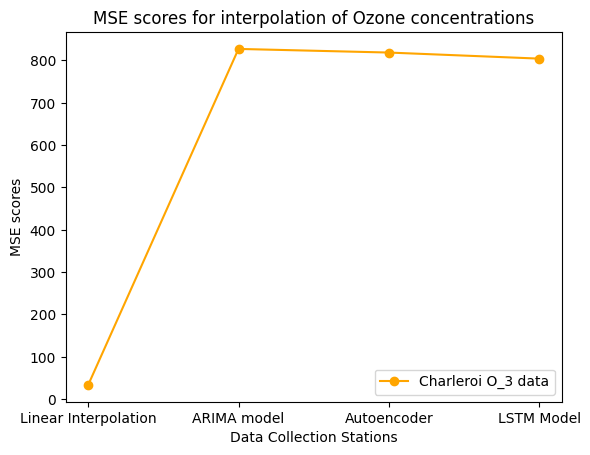

In [ ]:
plt.plot(x_values, y_values_lininter, label='Charleroi O_3 data', marker='o', color='orange')
plt.xlabel('Data Collection Stations')
plt.ylabel('MSE scores')
plt.title('MSE scores for interpolation of Ozone concentrations')
plt.legend()
plt.show()